# TRAIN KERAS MODEL - Ayukngaji 

In [209]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import random
from tensorflow.python.platform import gfile
import librosa

#for removing future warnings
import warnings
warnings.filterwarnings('ignore')

Note: import keras seperti ini.

In [210]:
# from tf.keras.models import Sequential  # Tidak bisa!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [211]:
tf.__version__

'1.6.0'

In [212]:
tf.keras.__version__

'2.1.3-tf'

## Manual load Spectogram

Berikut tools untuk load batch

In [213]:
"""
DAAATASET
"""
DEBUG = False
PATH_TRAIN = os.getcwd()+'/data/train'
PATH_TEST = os.getcwd()+'/data/test'
LOGDIR = 'log/'
TEST_LOGDIR = 'log_test/'
LABEL_TO_INDEX_MAP = {}
WIDTH = 1025
HEIGHT = 44
NUM_LABELS = 0
BATCHRUN = 500
EPOCHS = 5

In [214]:
def init(path):
    labels = os.listdir(path)
    index = 0
    for label in labels:
        LABEL_TO_INDEX_MAP[label] = index
        index += 1
        
    global NUM_LABELS
    NUM_LABELS = len(LABEL_TO_INDEX_MAP)
    print(LABEL_TO_INDEX_MAP)

In [215]:
def one_hot_encoding(label):
    encoding = [0] * len(LABEL_TO_INDEX_MAP)
    encoding[LABEL_TO_INDEX_MAP[label]] = 1
    return encoding

In [227]:
def get_mfcc(wave_path, PAD_WIDTH=WIDTH):
    if DEBUG:
        print(wave_path)
    wave, sr = librosa.load(wave_path, mono=True, duration=0.5)
    mfccs = librosa.amplitude_to_db(librosa.stft(wave))
    #mfccs = librosa.feature.mfcc(wave,sr=22050,n_mfcc=HEIGHT)
    mfccs = np.pad(mfccs,((0,0), (0, PAD_WIDTH - len(mfccs[0]))), mode='constant')
    return mfccs

In [217]:
def get_batch(batch_size, path):
    X = []
    Y = []
    random.seed(5896)
    path = os.path.join(path,'*', '*.wav')
    waves = gfile.Glob(path)
    while True:
        random.shuffle(waves)
        for wave_path in waves:
            _,label = os.path.split(os.path.dirname(wave_path))
            X.append(get_mfcc(wave_path))
            Y.append(one_hot_encoding(label))

            if (len(X) == batch_size):
                yield X, Y
                X = []
                Y = []

In [218]:
def my_plot(data, title=""):
    H = data
    fig = plt.figure(figsize=(2, 2))

    ax = fig.add_subplot(111)
    ax.set_title(title)
    plt.imshow(H)
    ax.set_aspect('equal')

    #cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()

## Data Dimensions

setting ukuran matriks

In [219]:
# We know that MNIST images are 28 pixels in each dimension.
img_size_x = WIDTH
img_size_y = HEIGHT

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size_x * img_size_y

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size_x, img_size_y)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size_x, img_size_y, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 6

### Helper-function buat plot gambar

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [220]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Ini cara loading lama

In [221]:
# Get the first images from the test-set.
#images = data.test.images[0:9]

#Get the true classes for those images.
#cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
#plot_images(images=images, cls_true=cls_true)

### Helper-function

Buat plotting - tapi belum jalan

In [222]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.test.cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## Sequential Model

Model dari Keras

In [223]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling. (kernel 5, filters 16)
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling. (def kernel=5 filters 36)
model.add(Conv2D(kernel_size=5, strides=1, filters=81, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax'))

### Kompilasi Model

Kompilasi model

In [224]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-5)

For a classification-problem such as MNIST which has 10 possible classes, we need to use the loss-function called `categorical_crossentropy`. The performance metric we are interested in is the classification accuracy.

In [225]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

Tempat training keseluruhan

In [226]:
init(PATH_TRAIN)
batch = get_batch(BATCHRUN,PATH_TRAIN)
X, Y = next(batch)

for i in range(len(X)):
    X[i]=X[i].reshape((WIDTH*HEIGHT,))

{'ba': 0, 'ju': 1, 'mi': 2, 'nu': 3, 'si': 4, 'ta': 5}


ValueError: cannot reshape array of size 1050625 into shape (45100,)

In [181]:
#check bentuk X -> (1100,)
X[1].shape

(1050625,)

In [182]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest'
               )
    plt.show()

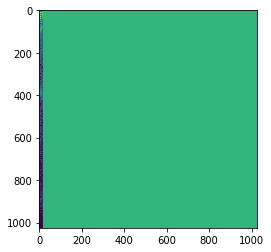

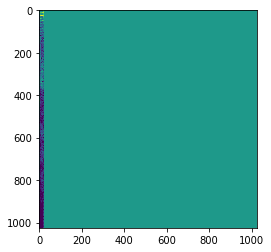

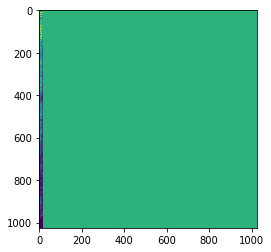

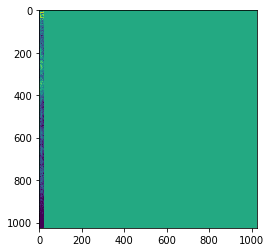

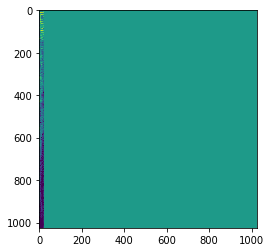

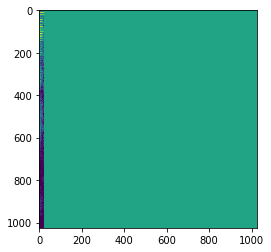

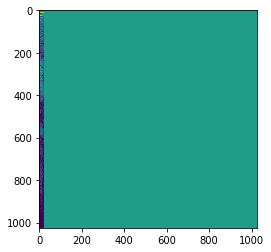

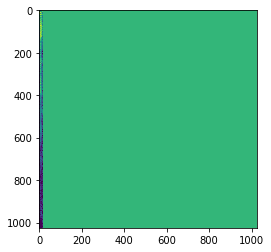

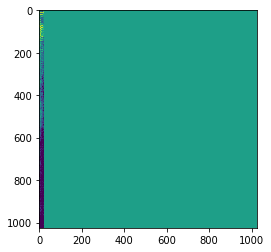

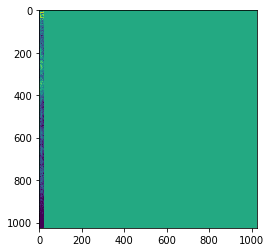

In [183]:
for i in X[10:20]:
    plot_image(i)

# STOP TRAINING DISINI

In [63]:
EPOCHS = 50
model.fit(x=np.array(X),
          y=np.array(Y),
          epochs=EPOCHS, batch_size=BATCHRUN)

Epoch 1/50
500/500 [==============================]500/500 [==============================] - 0s 887us/step - loss: 1.5748 - acc: 0.7820

Epoch 2/50
500/500 [==============================]500/500 [==============================] - 0s 873us/step - loss: 1.4051 - acc: 0.7820

Epoch 3/50
500/500 [==============================]500/500 [==============================] - 0s 946us/step - loss: 1.2292 - acc: 0.7820

Epoch 4/50
500/500 [==============================]500/500 [==============================] - 0s 884us/step - loss: 1.0596 - acc: 0.7820

Epoch 5/50
500/500 [==============================]500/500 [==============================] - 0s 900us/step - loss: 0.9073 - acc: 0.8360

Epoch 6/50
500/500 [==============================]500/500 [==============================] - 0s 909us/step - loss: 0.7924 - acc: 0.8360

Epoch 7/50
500/500 [==============================]500/500 [==============================] - 0s 885us/step - loss: 0.7290 - acc: 0.8900

Epoch 8/50
500/500 [==============

### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [23]:
result = model.evaluate(x=np.array(X),
                        y=np.array(Y))

500/500 [==============================]500/500 [==============================] - 0s 249us/step



Print performa test

In [24]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 2.4680696754455567
acc 0.8479999995231629


Or we can just print the classification accuracy.

In [25]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 84.80%


### Prediksi

coba disini bikin prediksi

In [26]:
y_pred = model.predict(x=np.array(X))

Ambil prediksi jadikan integer

In [27]:
cls_pred = np.argmax(y_pred,axis=1)

In [28]:
#plot gak bisa
#plot_images(images=images,
#            cls_true=cls_true,
#            cls_pred=cls_pred)

### Mis-Classified

mencoba prediksi dan test model

In [29]:
y_pred = model.predict(x=np.array(X))

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [30]:
cls_pred = np.argmax(y_pred,axis=1)

Plot some of the mis-classified images.

## Save & Load Model

In [31]:
path_model = 'model.keras'

In [32]:
model.save(path_model)

Hapus model

In [199]:
del model

Import lagi

In [309]:
from tensorflow.python.keras.models import load_model

Panggil model

In [310]:
model3 = load_model(path_model)

Coba test model yang di load

In [ ]:
BATCHRUN=10
init(PATH_TEST)
batch = get_batch(BATCHRUN,PATH_TEST)
X, Y = next(batch)

for i in range(len(X)):
    X[i]=X[i].reshape((25*30,))
    
images = np.array(X)

{'ba': 0, 'ju': 1, 'mi': 2, 'nu': 3, 'si': 4, 'ta': 5}


In [ ]:
cls_true = np.array(Y)

We then use the restored model to predict the class-numbers for those images.

In [ ]:
y_pred = model3.predict(x=images)

In [ ]:
y_pred[1]

Get the class-numbers as integers.

In [ ]:
cls_pred = np.argmax(y_pred, axis=1)

In [ ]:
cls_pred

In [ ]:
#Cek akurasi
for name, value in zip(model.metrics_names, result):
    print(name, value)

# PLOT LAYERS

In [ ]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
layer_input = model.layers[0]
layer_conv1 = model.layers[2]
layer_conv2 = model.layers[4]
weights_conv1 = layer_conv2.get_weights()[0]
plot_conv_weights(weights=weights_conv1, input_channel=0)

In [40]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [84]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest'
               )

    plt.show()

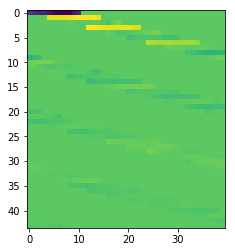

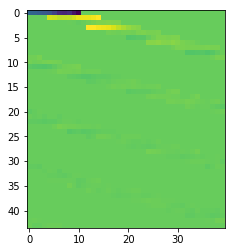

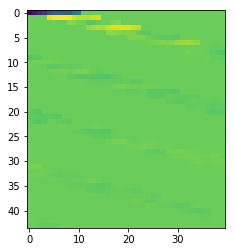

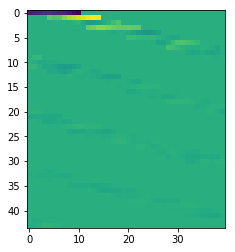

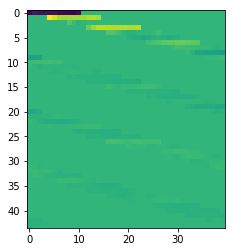

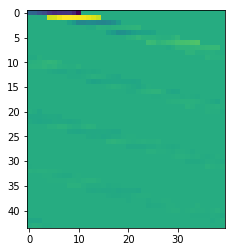

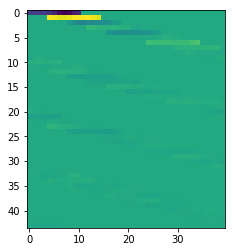

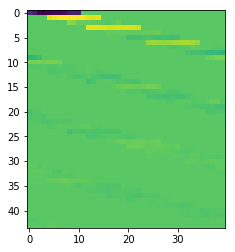

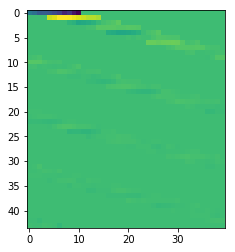

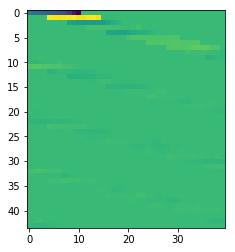

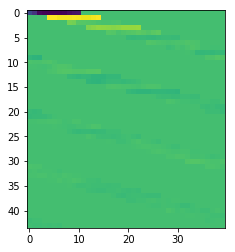

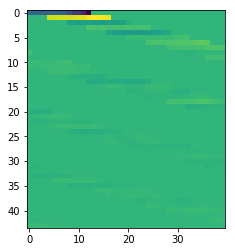

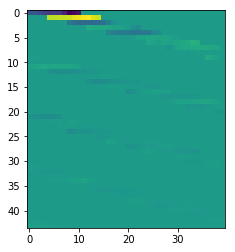

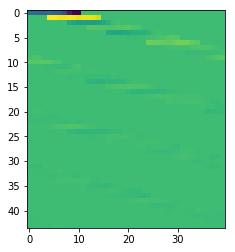

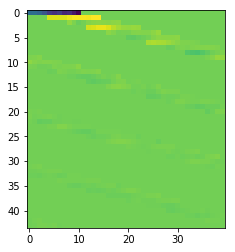

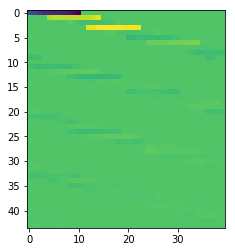

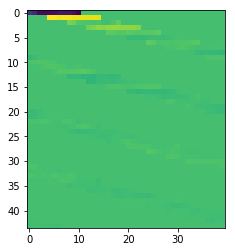

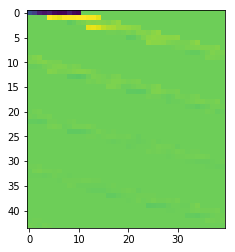

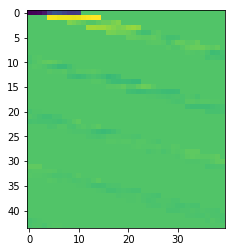

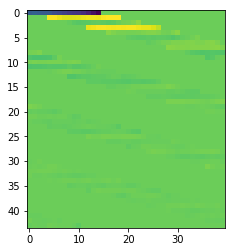

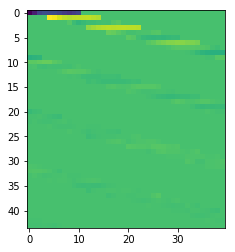

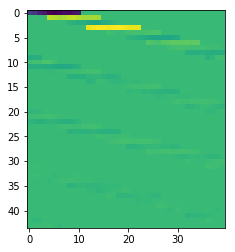

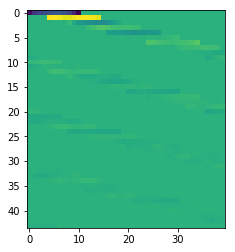

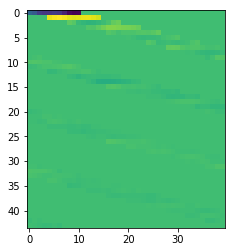

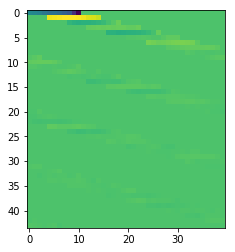

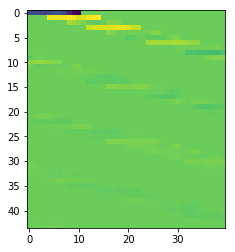

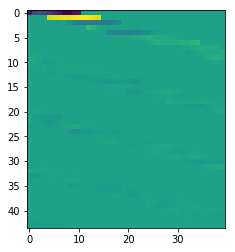

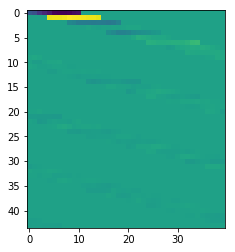

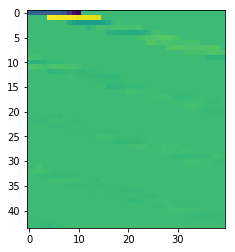

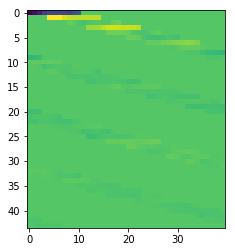

In [85]:
for i in range(50,80):
    plot_image(np.array(X[i]).reshape(1,WIDTH*HEIGHT))


# TEST DISINI

In [65]:
%matplotlib inline
import IPython.display as ipd
from ipywidgets import interact, interactive, fixed

import os
import audioop
import pyaudio
import wave
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import copy
from scipy.signal import butter, lfilter
import scipy.ndimage
import librosa
import librosa.display
import random

class AudioFile:
    chunk = 2048
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    length_capture = 20  #20 ms
    overlap_frame = 4    #4 ms
    start_at = 7         #maybe not used
    end_at = 100
    DEBUG = False

    def __init__(self, file):
        self.file = file

    def play(self):
        self.wf = wave.open(self.file, 'rb')

        # instantiate PyAudio (1)
        self.p = pyaudio.PyAudio()

        # open stream (2)
        self.stream = self.p.open(format=self.p.get_format_from_width(self.wf.getsampwidth()),
                channels=self.wf.getnchannels(),
                rate=self.wf.getframerate(),
                output=True)

        # read data
        self.data = self.wf.readframes(self.chunk)

        # play stream (3)
        while len(self.data) > 0:
            self.stream.write(self.data)
            self.data = self.wf.readframes(self.chunk)

        # stop stream (4)
        self.stream.stop_stream()
        self.stream.close()

        # close PyAudio (5)
        self.p.terminate()

    def record(self, length=3, thres=600):
        self.p = pyaudio.PyAudio()
 
        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
        self.frames = []
        self.temp_frames = []
        print("Recording")
        for i in range(0, int(self.RATE / self.chunk * length)):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            if rms >= thres:
                self.frames.append(data)
           
                
        print("finished recording")
 
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        
        self.wf = wave.open(self.file, 'wb')
        self.wf.setnchannels(self.CHANNELS)
        self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
        self.wf.setframerate(self.RATE)
        self.wf.writeframes(b''.join(self.frames))
        self.wf.close() 
        
    def plot(self,bgn,lst):
        # read audio samples
        input_data = read(self.file)
        audio = input_data[1]
        
        #put to normalize
        audio = audio / (2.**(16-1))  # normalize

        plt.plot(audio[bgn:lst])
        # label the axes
        plt.ylabel("Amplitude")
        plt.xlabel("Time")
        # set the title  
        plt.title("Recorded Wav")
        # display the plot
        plt.show()
        # Usage example for pyaudio

    def libplot(self):
        wave, sr = librosa.load(self.file, mono=True)
        plt.figure(figsize=(12,4))
        librosa.display.waveplot(wave, sr=sr)
    
    def plotfile(self, title):
        wave, sr = librosa.load(self.file, mono=True)
        plt.figure(figsize=(12,4))
        plt.title(title)
        librosa.display.waveplot(wave, sr=sr)
   
    def libspec(self):
        wave, sr = librosa.load(self.file, mono=True)
        D = librosa.stft(wave,hop_length=64)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(librosa.amplitude_to_db(librosa.magphase(D)[0],ref=np.max),
            y_axis='log', x_axis='time')
        plt.title('Power spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        
    def aufile(self):
        return self.file
    
    def stream_pred(self, length=3, thres=600, frame=5):
        self.p = pyaudio.PyAudio()


        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
 
        self.frames = []
        self.temp_frames = []
        self.captured = []
        self.captured_frame_count = 0
        self.the_overlap=[]

        print("Recording")
        
        self.fl=0
        for i in range(0, int(self.RATE / self.chunk * length)):
            self.fl += 1
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            
            if rms >= thres:
                
                self.matrx = []
                self.frames.append(data)

                if self.fl>=frame:
                    f=mfcc_dat(data,n_mfcc=HEIGHT,PAD_WIDTH=WIDTH)
                    y_pred = model.predict(x=f.reshape(1,WIDTH*HEIGHT))
                    cls_pred = np.argmax(y_pred, axis=1)
                    print(list(LABEL_TO_INDEX_MAP)[int(cls_pred)])
                    self.fl=0

                
        print("finished recording")
        #print(len(self.frames))
        #print(len(self.frames[1]))
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        self.files=[]
        for i in range(len(self.frames)):
            self.fnm=self.file
            self.fn = self.fnm.split('.wav')[0]
            if self.DEBUG: print(self.fn)
            self.fn = self.fn + str(i)+'-f.wav'
            
            self.files.append(self.fn)
            
            self.wf = wave.open(self.fn, 'wb')
            self.wf.setnchannels(self.CHANNELS)
            self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
            self.wf.setframerate(self.RATE)
            self.frm = []
            for s in range(frame):
                if (i+s)<len(self.frames):
                    self.frm.extend(self.frames[i+s])

                
            self.wf.writeframes(bytes(self.frm))
            
            #self.wf.writeframes(b''.join([self.frames[i]]))
            self.wf.close()
        return self.files

In [66]:
def mfcc_dat(data, n_mfcc=HEIGHT, PAD_WIDTH=WIDTH):
    a = list(data)
    a = np.array(a,dtype=float)
    f = librosa.feature.mfcc(a, n_mfcc=n_mfcc)
    mfccs = np.pad(f,((0,0), (0, PAD_WIDTH - len(f[0]))), mode='constant')
    return mfccs

In [68]:
a = AudioFile('test.wav')
lst = a.stream_pred(length=3,thres=800,frame=2)

Recording
ju
ju
ju
ju
ju
finished recording


In [78]:
import generator as gn

E:\data\python\3.6\Keras-Ayukngaji/data/train/ba
E:\data\python\3.6\Keras-Ayukngaji/data/train/ta
E:\data\python\3.6\Keras-Ayukngaji/data/train/si
E:\data\python\3.6\Keras-Ayukngaji/data/train/mi
E:\data\python\3.6\Keras-Ayukngaji/data/train/nu
E:\data\python\3.6\Keras-Ayukngaji/data/train/ju


[NbConvertApp] Converting notebook generator.ipynb to script
[NbConvertApp] Writing 12464 bytes to generator.py


In [281]:
a = gn.AudioFile("start.wav")

In [286]:
gn.generate

In [29]:
def array_file(filename):
    wav, sr = librosa.load(filename, sr=22050)
    pad = mfcc_dat(wav)
    return pad

def pred_file(filename):
    f = array_file(filename)
    y_pred = model.predict(x=f.reshape(1,WIDTH*HEIGHT))
    cls_pred = np.argmax(y_pred, axis=1)
    print(list(LABEL_TO_INDEX_MAP)[int(cls_pred)])


In [30]:
for i in lst:
    print(i)
    pred_file(i)


test0-f.wav
nu
test1-f.wav
nu
test2-f.wav
nu
test3-f.wav
nu
test4-f.wav
nu
test5-f.wav
nu
test6-f.wav
nu
test7-f.wav
nu
test8-f.wav
nu
test9-f.wav
nu
test10-f.wav
ba
test11-f.wav
nu
test12-f.wav
ba
test13-f.wav
ba
test14-f.wav
ju


In [71]:
print(LABEL_TO_INDEX_MAP)
a = AudioFile('my_test.wav')
a.record(3,400)
pred_file('my_test.wav')

{'ba': 0, 'ju': 1, 'mi': 2, 'nu': 3, 'si': 4, 'ta': 5}
Recording
finished recording
ta


# BARU SAMPAI SINI----

In [78]:
plot_images(images=images,
            cls_pred=cls_pred,
            cls_true=cls_true)

NameError: name 'images' is not defined

## Visualization of Layer Weights and Outputs

### Helper-function for plotting convolutional weights

In [79]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Get Layers

Keras has a simple way of listing the layers in the model.

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1100)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 44, 25, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 44, 25, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 12, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 22, 12, 81)        32481     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 6, 81)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5346)              0         
__________

We count the indices to get the layers we want.

The input-layer has index 0.

In [81]:
layer_input = model.layers[0]

The first convolutional layer has index 2.

In [82]:
layer_conv1 = model.layers[2]
layer_conv1

The second convolutional layer has index 4.

In [83]:
layer_conv2 = model.layers[4]

### Convolutional Weights

Now that we have the layers we can easily get their weights.

In [84]:
weights_conv1 = layer_conv1.get_weights()[0]

This gives us a 4-rank tensor.

In [85]:
weights_conv1.shape

(5, 5, 1, 16)

Plot the weights using the helper-function from above.

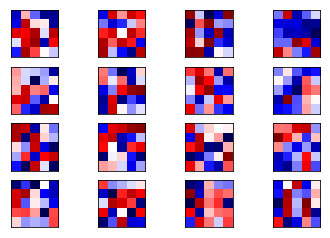

In [86]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

We can also get the weights for the second convolutional layer and plot them.

In [87]:
weights_conv2 = layer_conv2.get_weights()[0]

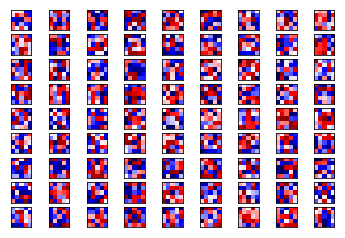

In [89]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

### Helper-function for plotting the output of a convolutional layer

In [90]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Image

Helper-function for plotting a single image.

In [91]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

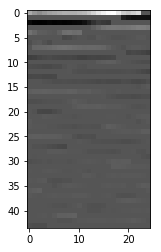

In [100]:
image1 = X[8]
plot_image(image1)

### Output of Convolutional Layer - Method 1

There are different ways of getting the output of a layer in a Keras model. This method uses a so-called K-function which turns a part of the Keras model into a function.

In [93]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model

In [94]:
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])

We can then call this function with the input image. Note that the image is wrapped in two lists because the function expects an array of that dimensionality. Likewise, the function returns an array with one more dimensionality than we want so we just take the first element.

In [95]:
layer_output1 = output_conv1([[image1]])[0]
layer_output1.shape

(1, 44, 25, 16)

We can then plot the output of all 16 channels of the convolutional layer.

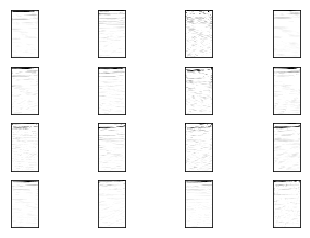

In [101]:
plot_conv_output(values=layer_output1)

### Output of Convolutional Layer - Method 2

Keras also has another method for getting the output of a layer inside the model. This creates another Functional Model using the same input as the original model, but the output is now taken from the convolutional layer that we are interested in.

In [97]:
output_conv2 = Model(inputs=layer_input.input,
                     outputs=layer_conv2.output)

This creates a new model-object where we can call the typical Keras functions. To get the output of the convoloutional layer we call the `predict()` function with the input image.

In [98]:
layer_output2 = output_conv2.predict(np.array([image1]))
layer_output2.shape

(1, 22, 12, 81)

We can then plot the images for all 36 channels.

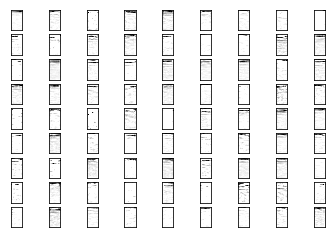

In [99]:
plot_conv_output(values=layer_output2)

## Conclusion

This tutorial showed how to use the so-called *Keras API* for easily building Convolutional Neural Networks in TensorFlow. Keras is by far the most complete and best designed API for TensorFlow.

This tutorial also showed how to use Keras to save and load a model, as well as getting the weights and outputs of convolutional layers.

It seems likely that Keras will be the standard API for TensorFlow in the future, for the simple reason that is already very good and it is constantly being improved. So it is recommended that you use Keras.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Train for more epochs. Does it improve the classification accuracy?
* Change the activation function to sigmoid for some of the layers.
* Can you find a simple way of changing the activation function for all the layers?
* Plot the output of the max-pooling layers instead of the conv-layers.
* Replace the 2x2 max-pooling layers with stride=2 in the convolutional layers. Is there a difference in classification accuracy? What if you optimize it again and again? The difference is random, so how would you measure if there really is a difference? What are the pros and cons of using max-pooling vs. stride in the conv-layer?
* Change the parameters for the layers, e.g. the kernel, depth, size, etc. What is the difference in time usage and classification accuracy?
* Add and remove some convolutional and fully-connected layers.
* What is the simplest network you can design that still performs well?
* Change the Functional Model so it has another convolutional layer that connects in parallel to the existing conv-layers before going into the dense layers.
* Change the Functional Model so it outputs the predicted class both as a One-Hot encoded array and as an integer, so we don't have to use `numpy.argmax()` afterwards.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.